In [35]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

import os
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score

In [36]:
current_path = os.getcwd()

print(current_path)

c:\Users\decem\Desktop\Exercise Files


In [37]:

df = pd.read_csv("SD_Project/UrbanSound8K/metadata/UrbanSound8K.csv")

data_size = len(df)

feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(data_size):
        file_name = 'SD_Project/Urbansound8k/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

temp = parser(df)
temp = np.array(temp)
data = temp.transpose()
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([data_size+1, 128])

# for unknown label 10= unknown
Y = np.append(Y,10)

for i in range(data_size):
    X[i] = (X_[i])

Y = to_categorical(Y)

test_size = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state = 1,test_size = test_size)
X_total,Y_total = shuffle(X, Y)
X_total = X_total.reshape(data_size+1,16,8,1)
X_train = X_train.reshape(round((data_size+1)*(1-test_size)),16,8,1)
X_test = X_test.reshape(round((data_size+1)*test_size),16,8,1)
input_dim = (16,8,1)
# input_dim is fixed to 128 as we use melspectrogram from librosa -> 16*8*1 = 128


C:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1323
  stft(
C:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1103
  stft(
C:\Users\decem\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:2538: UserWarning: n_fft=2048 is too small for input signal of length=1523
  stft(


(8732,) (8732,)


C:\Users\decem\AppData\Local\Temp/ipykernel_17364/2560934417.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


In [38]:
input_dim = (16,8,1)
model = Sequential()

model.add(Conv2D(32, (2,2), strides=1, padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2), strides=1))
model.add(Dropout(0.1))
model.add(Conv2D(128, (2,2), strides=1, padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2),strides=1))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(11, activation = "softmax"))

Optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = Optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train,Y_train, validation_split=0.1, epochs=90, batch_size=40)

Epoch 1/90
167/167 [==============================] - 10s 56ms/step - loss: 1.6894 - accuracy: 0.4659 - val_loss: 1.4600 - val_accuracy: 0.5195
Epoch 2/90
167/167 [==============================] - 9s 55ms/step - loss: 1.2495 - accuracy: 0.5783 - val_loss: 1.2364 - val_accuracy: 0.5976
Epoch 3/90
167/167 [==============================] - 9s 53ms/step - loss: 1.1107 - accuracy: 0.6260 - val_loss: 1.1693 - val_accuracy: 0.6258
Epoch 4/90
167/167 [==============================] - 9s 55ms/step - loss: 0.9846 - accuracy: 0.6635 - val_loss: 1.0102 - val_accuracy: 0.6676
Epoch 5/90
167/167 [==============================] - 9s 56ms/step - loss: 0.8994 - accuracy: 0.6927 - val_loss: 0.9238 - val_accuracy: 0.7026
Epoch 6/90
167/167 [==============================] - 9s 52ms/step - loss: 0.8191 - accuracy: 0.7196 - val_loss: 0.9933 - val_accuracy: 0.6837
Epoch 7/90
167/167 [==============================] - 8s 51ms/step - loss: 0.7676 - accuracy: 0.7421 - val_loss: 0.8905 - val_accuracy: 0.707

In [39]:
def unknown_pred(predictions, threshold):
    new_predict = predictions
    for i in range(len(predictions)):
        for j in range(len(predictions[0])):
            if new_predict[i][j]< threshold:
                new_predict[i][j]=0

    new_predict= np.array(new_predict)
    for i in range(len(new_predict)):
        if max(new_predict[i]) != 0:
            new_predict[i][10] = 0
        else:
            new_predict[i][10] = 1


    return new_predict

In [40]:
predictions = model.predict(X_test, batch_size = 30)
score = model.evaluate(X_test, Y_test)
PM_2 = unknown_pred(predictions, 0.5)
round_preds = np.argmax(PM_2, axis = -1)
round_y = np.argmax(Y_test, axis = -1)

41/41 [==============================] - 0s 8ms/step - loss: 0.5660 - accuracy: 0.8817


In [41]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[141   0   1   0   0   3   0   0   0   1   5]
 [  1  66   2   1   0   0   0   0   1   2   0]
 [  1   0 102  20   0   1   0   0  10   4   3]
 [  3   1   8 117   0   1   1   0   6   2   4]
 [  3   1   1   1 131   0   1   3   0   4   1]
 [  1   0   2   0   1 142   0   0   1   2   0]
 [  0   0   4   0   1   0  55   1   2   1   0]
 [  0   1   2   0   6   0   0 164   0   1   2]
 [  0   0   3   5   0   1   0   0 127   0   1]
 [  1   4   5   5   3   0   0   0   3 106   3]
 [  0   0   0   0   0   0   0   0   0   0   0]]


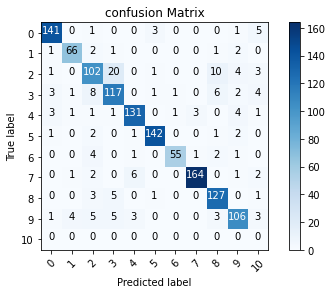

In [42]:
cm_plot_labels = [0,1,2,3,4,5,6,7,8,9,10]
conf_mat = confusion_matrix(y_true = round_y , y_pred=round_preds, labels=cm_plot_labels)
plot_confusion_matrix(cm=conf_mat, classes=cm_plot_labels, title='confusion Matrix')

In [43]:
counter = 1
while True:
    file_name = "N_Model_" + str(counter) + ".h5"
    if os.path.isfile(file_name) is False:
        model.save(file_name)
        break
    else:
        counter = counter +1

In [44]:
print(f1_score(round_y, round_preds, average='macro'))
print(f1_score(round_y, round_preds, average='micro'))
print(f1_score(round_y, round_preds, average=None))
print(f1_score(round_y, round_preds, average='weighted'))

0.8039558508578797
0.8786259541984733
[0.93377483 0.90410959 0.75276753 0.80136986 0.90972222 0.95622896
 0.90909091 0.95348837 0.88501742 0.83794466 0.        ]
0.8848928515187897
